<a href="https://colab.research.google.com/github/su-sumico/seminar/blob/main/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert

# Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Deep learning/sc_nlp/

Mounted at /content/drive
/content/drive/MyDrive/Deep learning/sc_nlp


# Python環境の整備

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datasets import DatasetDict

# データの読込
data_df = pd.read_csv("/content/drive/MyDrive/Deep learning/sc_nlp/review_clean_p.csv",encoding='utf-8')
data_df = data_df.drop(columns=data_df.columns[0])
data_df = data_df.rename(columns = { 'text' : 'sentence' }) # 元の文

# データ抽出(train, validation)
train_df = data_df.loc[0:599, ["label","sentence"]].replace("P", 1).replace("N", 0)
validation_df = data_df.loc[600:799, ["label", "sentence"]].replace("P", 1).replace("N", 0)
test_df = data_df.loc[800:999, ["label", "sentence"]].replace("P", 1).replace("N", 0)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
validation_dataset = Dataset.from_pandas(validation_df)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset
})
data_df

,label,sentence
0,N,Ｐ２Ｐは画期的な技術らしいが、どう画期的なのかもう少し作中で教えて欲しかった。作中に入りきら...
1,N,Ｐ２Ｐは画期的な技術らしいが、どう画期的なのかもう少し作中で教えて欲しかった。作中に入りきら...
2,N,ウィニーを作るのが早すぎたのか遅すぎたのか。というセリフがかなり印象的だった。ただ、日本の警...
3,N,興味のない分野だと敬遠していたけど、面白かったな...。地味ですごくよかった。苦手な三浦貴大...
4,N,ファイル共有ソフトを作成した技術者が京都府警に逮捕された出来事を元にした作品。映画の演出もあ...
...,...,...
995,P,神がいない宗教と言っていい。ある種の思想家であるし、新思想を技術者が創出してる時点でフリーメ...
996,P,日本の宝を奪った警察が許せない。この作品が少しでも金子勇さんの慰めになりますように。
997,P,金子さんって本当にこういう方だったんだろうなあと無罪のとこまで見たかった、、、、
998,P,エンジニアとしてのあり方を見た気がした。私も｢山があるから登る｣ようなエンジニアになりたい。...


In [ ]:
!pip install fugashi
!pip install ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=9e69ea1345da65c9ab538cc2215f4e8b578888d352d217d8c2e605dd8634789b
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


In [ ]:
# トークナイザの取得
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")

# モデルの取得
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2
model = (AutoModelForSequenceClassification
    .from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking", num_labels=num_labels)
    .to(device))

# トークナイザ処理
def tokenize(batch):
    return tokenizer(batch["sentence"], padding=True, truncation=True)
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

# 学習の準備
batch_size = 16
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"classification"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error",
)

# 評価指標の定義
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    #2値分類ならaverage='binary'とする
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# 学習
trainer = Trainer(
    model=model, args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train()

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Parameter 'function'=<function tokenize at 0x7c6c577d7250> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.683300,0.437551,1.000000,1.000000,1.000000,1.000000
2,0.637700,0.488306,0.890000,1.000000,0.890000,0.941799
3,0.592700,0.459077,0.880000,1.000000,0.880000,0.936170


TrainOutput(global_step=114, training_loss=0.6360402901967367, metrics={'train_runtime': 45.2119, 'train_samples_per_second': 39.813, 'train_steps_per_second': 2.521, 'total_flos': 117474975108000.0, 'train_loss': 0.6360402901967367, 'epoch': 3.0})

正解率（Accuracy） = 86.50%
適合率（Precision） = 100.00%
再現率（Recall） = 86.50%
F1値（F1-score） = 92.76%


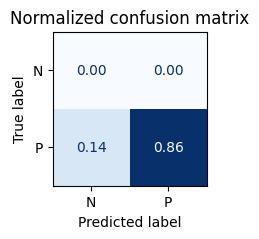

In [ ]:
preds_output = trainer.predict(dataset_encoded["test"])
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(dataset_encoded["test"]["label"])

precision, recall, f1_score, _ = precision_recall_fscore_support(y_valid, y_preds, average="binary")
print('正解率（Accuracy） = {:.2f}%'.format(100 * accuracy_score(y_valid, y_preds))) # 正解率を表示
print('適合率（Precision） = {:.2f}%'.format(100 * precision)) # 適合率を表示
print('再現率（Recall） = {:.2f}%'.format(100 * recall)) # 再現率を表示
print('F1値（F1-score） = {:.2f}%'.format(100 * f1_score)) #F1値を表示

labels = ['N', 'P']
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(2, 2))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid,labels)

In [ ]:
preds_df = pd.DataFrame({"predict" : y_preds})
csv_df = pd.concat([data_df.loc[800:999, ].replace("P", 1).replace("N", 0).reset_index(), preds_df], axis = 1)
csv_df["predict"] = csv_df["predict"].replace(1, "P").replace(0, "N")
csv_df["label"] = csv_df["label"].replace(1, "P").replace(0, "N")
csv_df.drop(columns=csv_df.columns[0]).to_csv("/content/drive/MyDrive/Deep learning/sc_nlp/tweets-bert.csv", encoding="utf-8")
#csv_df = csv_df.drop(columns=csv_df.columns[0])
csv_df

,index,label,sentence,predict
0,800,P,東出さん、監督、俳優さん皆さんの作品に対する愛情が伝わってきた。とても素晴らしい作品だと思い...,P
1,801,P,ノンフィクションベースのストーリー恥ずかしながらこのwinny事件を知らなくて、、事実関係を...,P
2,802,P,この7年が金子さんの創作活動に充てられてたなら、きっとYouTubeや LINEを越えるモノ...,P
3,803,P,エンジニアの方々が世の中のために、純粋にそして自由に開発を続けることが金子さんが頑張ってくれ...,P
4,804,P,実話なので不謹慎ですが面白い作品でした。金子さんが純粋な技術者なのがすごく伝わってきました。...,P
...,...,...,...,...
195,995,P,神がいない宗教と言っていい。ある種の思想家であるし、新思想を技術者が創出してる時点でフリーメ...,P
196,996,P,日本の宝を奪った警察が許せない。この作品が少しでも金子勇さんの慰めになりますように。,P
197,997,P,金子さんって本当にこういう方だったんだろうなあと無罪のとこまで見たかった、、、、,P
198,998,P,エンジニアとしてのあり方を見た気がした。私も｢山があるから登る｣ようなエンジニアになりたい。...,P
